In [35]:
import kabuki
import os
import hddm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from joblib import Parallel,delayed
from glob import glob
from kabuki.analyze import gelman_rubin
import arviz
import numpy as np
from patsy import dmatrix 

import ptitprince as pt

# rmANOVA
from statsmodels.stats.anova import AnovaRM


from sklearn.preprocessing import StandardScaler

In [31]:
# load data
data = hddm.load_csv('./data.csv')

# stimulus onset time is 200, we should add it.
data['rt']=data['rt']+0.2
data.loc[(data['response']==1)&(data['stimulus']=='face'),'_response'] = 'face' #face
data.loc[(data['response']==1)&(data['stimulus']=='car'),'_response'] = 'car' #car
data.loc[(data['response']==0)&(data['stimulus']=='face'),'_response'] = 'car'
data.loc[(data['response']==0)&(data['stimulus']=='car'),'_response'] = 'face'
# rt of correct time should be positive, and rt of incorrect time should be negative.


In [3]:
# link function for stimulus, one stimulus should be coded 0, another should be coded 1
def z_link_func(x, data=data):
        stim = (np.asarray(dmatrix('0 + C(s, [[0], [1]])',
                                  {'s': data.stimulus.loc[x.index]},return_type='dataframe'))
        )
        # Apply z = (1 - x) to flip them along 0.5
        z_flip = np.subtract(stim, x.to_frame())
        # The above inverts those values we do not want to flip,
        # so invert them back
        z_flip[stim == 0] *= -1
        return z_flip


In [4]:
def v_link_func(x, data=data):
    stim = (np.asarray(dmatrix('0 + C(s,[[1],[-1]])', {'s':data.stimulus.ioc[x.index]})))
    return x * stim

In [5]:
data

,rt,response,subj_idx,attention,coherency,prioritization,stimulus,run,_response,id,cpp_peak,cpp_slope,cpp_amplitude,index
0,0.433677,1.0,17,double,high,no,face,1,face,0,-8.079517e-07,-0.000004,2.028027e-06,0.0
1,0.551817,1.0,16,right,high,yes,face,1,face,0,-2.689282e-07,-0.000004,2.684621e-06,0.0
2,0.587365,1.0,15,double,high,no,face,1,face,0,2.485908e-06,0.000019,3.384187e-06,0.0
3,1.066449,1.0,14,left,high,yes,car,1,car,0,3.637858e-06,-0.000061,-3.439111e-06,0.0
4,0.589671,1.0,13,double,high,no,face,1,face,0,4.947688e-06,-0.000034,5.700386e-06,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3656,0.501089,1.0,7,left,high,yes,car,2,car,143,4.736038e-06,-0.000008,2.267714e-06,287.0
3657,1.568623,1.0,6,double,low,no,face,2,face,143,-7.884860e-07,-0.000008,-2.597419e-06,287.0
3658,0.471034,1.0,5,left,low,yes,car,2,car,143,7.526509e-06,-0.000039,1.188412e-06,287.0
3659,0.915909,1.0,3,double,low,no,car,2,car,143,4.439253e-06,-0.000018,6.979216e-07,287.0


In [43]:
data.loc[data['response']==0,'rt'] = -data.loc[data['response']==0,'rt']

<AxesSubplot:>

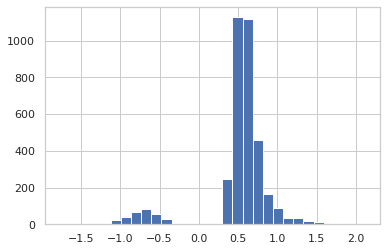

In [51]:
data.rt.hist(bins=30)

<AxesSubplot:ylabel='Density'>

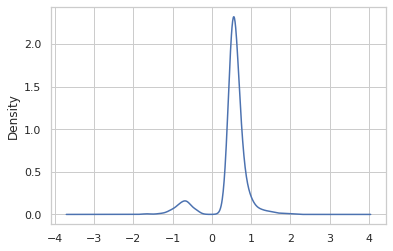

In [44]:
data.rt.plot.kde()

coherency
high    AxesSubplot(0.125,0.125;0.775x0.755)
low     AxesSubplot(0.125,0.125;0.775x0.755)
Name: rt, dtype: object

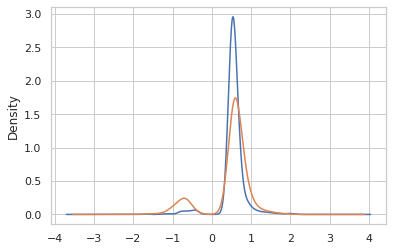

In [47]:
data.groupby(['coherency']).rt.plot.kde()

prioritization
no     AxesSubplot(0.125,0.125;0.775x0.755)
yes    AxesSubplot(0.125,0.125;0.775x0.755)
Name: rt, dtype: object

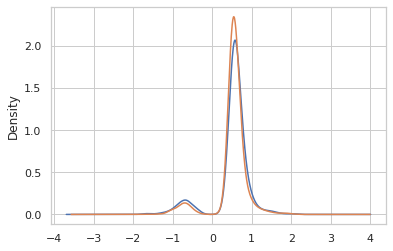

In [49]:
data.groupby(['prioritization']).rt.plot.kde()

stimulus
car     AxesSubplot(0.125,0.125;0.775x0.755)
face    AxesSubplot(0.125,0.125;0.775x0.755)
Name: rt, dtype: object

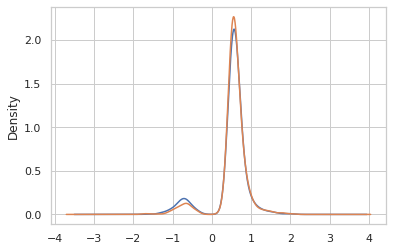

In [50]:
data.groupby(['stimulus']).rt.plot.kde()

In [6]:
data.groupby(['stimulus','response'])['rt'].agg(['size','mean','std'])

size      mean       std
stimulus response                          
car      0.0        190  0.755863  0.238256
         1.0       1639  0.627664  0.204340
face     0.0        131  0.749106  0.269298
         1.0       1701  0.625304  0.213569

In [7]:
data.groupby(['coherency','response'])['rt'].agg(['size','mean','std'])

size      mean       std
coherency response                          
high      0.0         67  0.660657  0.295406
          1.0       1777  0.591259  0.195079
low       0.0        254  0.777491  0.232506
          1.0       1563  0.666485  0.217138

In [8]:
data.groupby(['prioritization','response'])['rt'].agg(['size','mean','std'])

size      mean       std
prioritization response                          
no             0.0        189  0.752940  0.269714
               1.0       1650  0.643743  0.210086
yes            0.0        132  0.753341  0.222477
               1.0       1690  0.609590  0.206733

In [9]:
data.groupby(['stimulus','coherency','response'])['rt'].agg(['size','mean','std'])

size      mean       std
stimulus coherency response                          
car      high      0.0         40  0.710112  0.290531
                   1.0        879  0.596387  0.193086
         low       0.0        150  0.768063  0.221811
                   1.0        760  0.663838  0.211047
face     high      0.0         27  0.587389  0.292521
                   1.0        898  0.586240  0.196988
         low       0.0        104  0.791090  0.247582
                   1.0        803  0.668990  0.222851

In [10]:
data.groupby(['stimulus','prioritization','response'])['rt'].agg(['size','mean','std'])

size      mean       std
stimulus prioritization response                          
car      no             0.0        107  0.755472  0.256282
                        1.0        809  0.644704  0.207353
         yes            0.0         83  0.756367  0.214323
                        1.0        830  0.611055  0.200092
face     no             0.0         82  0.749638  0.287871
                        1.0        841  0.642819  0.212800
         yes            0.0         49  0.748217  0.237842
                        1.0        860  0.608176  0.213052

In [11]:
data.groupby(['stimulus','coherency','prioritization','response'])['rt'].agg(['size','mean','std'])

size      mean       std
stimulus coherency prioritization response                          
car      high      no             0.0         25  0.754889  0.309380
                                  1.0        432  0.616055  0.198564
                   yes            0.0         15  0.635484  0.248001
                                  1.0        447  0.577379  0.185891
         low       no             0.0         82  0.755649  0.239983
                                  1.0        377  0.677533  0.212545
                   yes            0.0         68  0.783032  0.198427
                                  1.0        383  0.650357  0.208964
face     high      no             0.0         20  0.603985  0.333917
                                  1.0        449  0.604094  0.194452
                   yes            0.0          7  0.539974  0.119046
                                  1.0        449  0.568386  0.198104
         low       no             0.0         62  0.796623  0.257120
                                  1.0        392  0.687175  0.224203
                   yes            0.0         42  0.782924  0.235617
                                  1.0        411  0.651645  0.220430

In [12]:
data.groupby(['response'])['rt'].agg(['size','mean','std'])

,size,mean,std
response,,,
0.0,321,0.753105,0.250999
1.0,3340,0.626462,0.209063


In [13]:
data.groupby(['response'])['rt'].agg(['size','mean','std'])

,size,mean,std
response,,,
0.0,321,0.753105,0.250999
1.0,3340,0.626462,0.209063


In [14]:
# ANOVA
model_aovrm2way = AnovaRM(data,
                   'rt',
                   'subj_idx',
                   within=['coherency','prioritization','stimulus'],
                   aggregate_func='mean')
res2way=model_aovrm2way.fit()
print(res2way)


                             Anova
                                  F Value Num DF  Den DF Pr > F
---------------------------------------------------------------
coherency                         31.2938 1.0000 14.0000 0.0001
prioritization                    14.7310 1.0000 14.0000 0.0018
stimulus                           0.3557 1.0000 14.0000 0.5604
coherency:prioritization           0.4077 1.0000 14.0000 0.5334
coherency:stimulus                 1.4786 1.0000 14.0000 0.2441
prioritization:stimulus            0.6021 1.0000 14.0000 0.4507
coherency:prioritization:stimulus  2.2998 1.0000 14.0000 0.1516



In [15]:
# ANOVA
model_aovrm2way = AnovaRM(data,
                   'response',
                   'subj_idx',
                   within=['coherency','prioritization','stimulus'],
                   aggregate_func='mean')
res2way=model_aovrm2way.fit()
print(res2way)


                             Anova
                                  F Value Num DF  Den DF Pr > F
---------------------------------------------------------------
coherency                         41.0433 1.0000 14.0000 0.0000
prioritization                     5.9287 1.0000 14.0000 0.0289
stimulus                           3.2638 1.0000 14.0000 0.0924
coherency:prioritization           0.4158 1.0000 14.0000 0.5295
coherency:stimulus                 1.6266 1.0000 14.0000 0.2229
prioritization:stimulus            0.4960 1.0000 14.0000 0.4928
coherency:prioritization:stimulus  0.0337 1.0000 14.0000 0.8569



In [22]:
df['attention']

,attention,attention
0,double,no
1,right,yes
2,double,no
3,left,yes
4,double,no
...,...,...
3656,left,yes
3657,double,no
3658,left,yes
3659,double,no


In [32]:
# get the mean of accurate RTs
data = data.drop(columns=['attention'])
df=data.rename(columns={'coherency':'coherence','prioritization':'attention'})
data_rt_sum = df[df['response']==1].groupby(['subj_idx','coherence','attention','stimulus'])['rt'].mean().reset_index()
# change the type of columns
#data_rt_sum['stimulus'] = data_rt_sum['stimulus'].astype('int64')
#data_rt_sum['coherence'] = data_rt_sum['coherence'].astype('int64')
#data_rt_sum['attention'] = data_rt_sum['attention'].astype('int64')

# set the figure theme
sns.set_theme(style="whitegrid")

In [41]:
 data_rt_sum =  data_rt_sum.replace({'high':1,'low':0,'yes':1,'low':0,'car':0,'face':1})

Text(0.5, 1, 'Response Time by Coherence and Attention')

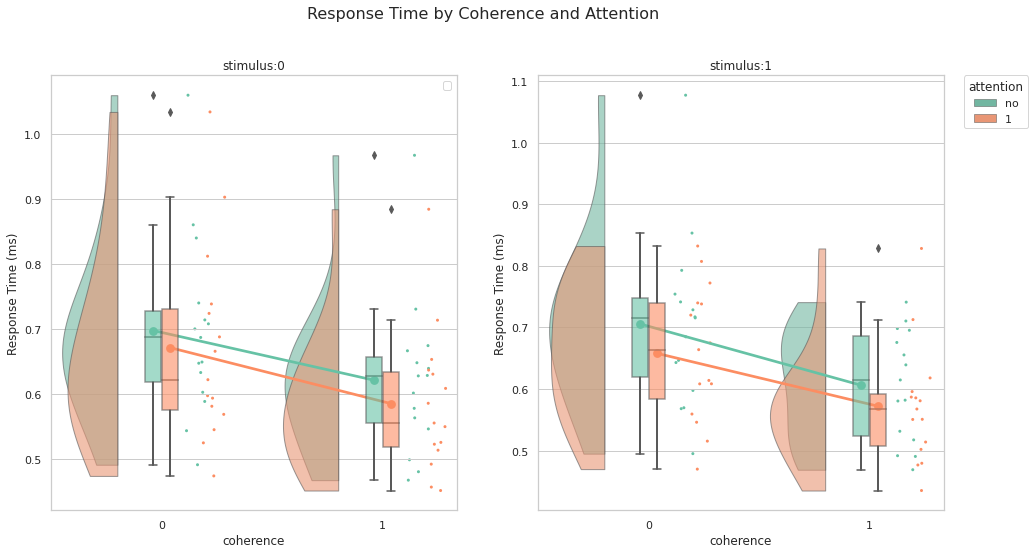

In [42]:
f, ax = plt.subplots(1,2,figsize=(16, 8))
# the left figure
ax[0] = pt.RainCloud(x = 'coherence', 
                  y = 'rt', 
                  hue = 'attention', 
                  data = data_rt_sum[data_rt_sum['stimulus']==0], 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  ax = ax[0], 
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True, 
                  pointplot = True, 
                  move = 0.2)
ax[0].legend('')
ax[0].set_title('stimulus:0')
ax[0].set_ylabel('Response Time (ms)')
# the right figure
ax[1] = pt.RainCloud(x = 'coherence', 
                  y = 'rt', 
                  hue = 'attention', 
                  data = data_rt_sum[data_rt_sum['stimulus']==1], 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  ax = ax[1], 
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True, 
                  pointplot = True, 
                  move = 0.2)
ax[1].set_title('stimulus:1')
ax[1].set_ylabel('Response Time (ms)')
plt.suptitle("Response Time by Coherence and Attention", 
               y=1, 
               fontsize=16)